<a href="https://colab.research.google.com/github/LarsStorholt/EmotionClassification/blob/main/GRUemotionClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Flatten, LSTM, Input, Dropout, BatchNormalization, GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model


In [ ]:
# Load dataset
df = pd.read_csv('/content/emotions.csv')

In [ ]:
def preprocess_df(data):
  le = LabelEncoder()
  df['label'] = le.fit_transform(df['label'])
  features = [col for col in data.columns if 'fft' in col]
  y = df.pop('label')
  X = df[features].values

  # Normalize the data
  scaler = StandardScaler()
  X_scaled = scaler.fit_transform(X)

  # Split the data into train and test sets
  X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, train_size=0.8, random_state=123, stratify=y)
  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=123, train_size=0.7, stratify=y_train)

  X_train = np.array(X_train).reshape((X_train.shape[0],X_train.shape[1],1))
  X_test = np.array(X_test).reshape((X_test.shape[0],X_test.shape[1],1))

  # Encode labels to one hot vectors
  # 0 for 'NEGATIVE'
  # 1 for 'NEUTRAL'
  # 2 for 'POSITIVE'

  y_train = pd.get_dummies(y_train)
  y_test = pd.get_dummies(y_test)
  y_val = pd.get_dummies(y_val)

  return X_train, X_test, y_train, y_test, X_val, y_val

In [ ]:
 X_train, X_test, y_train, y_test, X_val, y_val = preprocess_df(df)

# Building Model

In [ ]:
input_gru = Input(shape=(X_train.shape[1], 1))

x_gru = GRU(256, return_sequences=True)(input_gru)
x_gru = Flatten()(x_gru)
y_gru = Dense(3, activation='softmax')(x_gru)

model_gru = Model(input_gru, y_gru)

model_gru.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1500, 1)]         0         
                                                                 
 gru_2 (GRU)                 (None, 1500, 256)         198912    
                                                                 
 flatten_2 (Flatten)         (None, 384000)            0         
                                                                 
 dense_2 (Dense)             (None, 3)                 1152003   
                                                                 
Total params: 1350915 (5.15 MB)
Trainable params: 1350915 (5.15 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


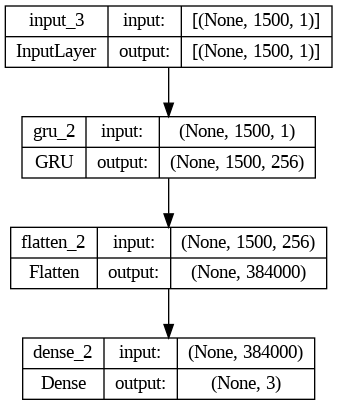

In [ ]:

plot_model(model_gru, to_file='model_gru.png', show_shapes=True, show_layer_names=True)


# Training Model

In [ ]:
adam = Adam(learning_rate=0.001)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)
mc = ModelCheckpoint('./best_gru_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
lr_schedule = LearningRateScheduler(lambda epoch: 0.001 * np.exp(-epoch / 10.))

model_gru.compile(optimizer=adam,
                  loss=['categorical_crossentropy'],
                  metrics=['accuracy'])

gru_h = model_gru.fit(X_train, y_train,
                   batch_size=32,
                   validation_data=(X_val, y_val),
                   epochs=20,
                   callbacks=[es, mc, lr_schedule])

Epoch 1/20
38/38 [==============================] - ETA: 0s - loss: 0.7942 - accuracy: 0.8215
Epoch 1: val_accuracy improved from -inf to 0.82031, saving model to ./best_gru_model.h5
38/38 [==============================] - 132s 3s/step - loss: 0.7942 - accuracy: 0.8215 - val_loss: 0.6484 - val_accuracy: 0.8203 - lr: 0.0010
Epoch 2/20


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


38/38 [==============================] - ETA: 0s - loss: 0.4225 - accuracy: 0.8567
Epoch 2: val_accuracy improved from 0.82031 to 0.90430, saving model to ./best_gru_model.h5
38/38 [==============================] - 129s 3s/step - loss: 0.4225 - accuracy: 0.8567 - val_loss: 0.4003 - val_accuracy: 0.9043 - lr: 9.0484e-04
Epoch 3/20
38/38 [==============================] - ETA: 0s - loss: 0.3410 - accuracy: 0.8910
Epoch 3: val_accuracy did not improve from 0.90430
38/38 [==============================] - 129s 3s/step - loss: 0.3410 - accuracy: 0.8910 - val_loss: 0.3582 - val_accuracy: 0.8926 - lr: 8.1873e-04
Epoch 4/20
38/38 [==============================] - ETA: 0s - loss: 0.3334 - accuracy: 0.8894
Epoch 4: val_accuracy did not improve from 0.90430
38/38 [==============================] - 131s 3s/step - loss: 0.3334 - accuracy: 0.8894 - val_loss: 0.3475 - val_accuracy: 0.9023 - lr: 7.4082e-04
Epoch 5/20
38/38 [==============================] - ETA: 0s - loss: 0.2899 - accuracy: 0.9078


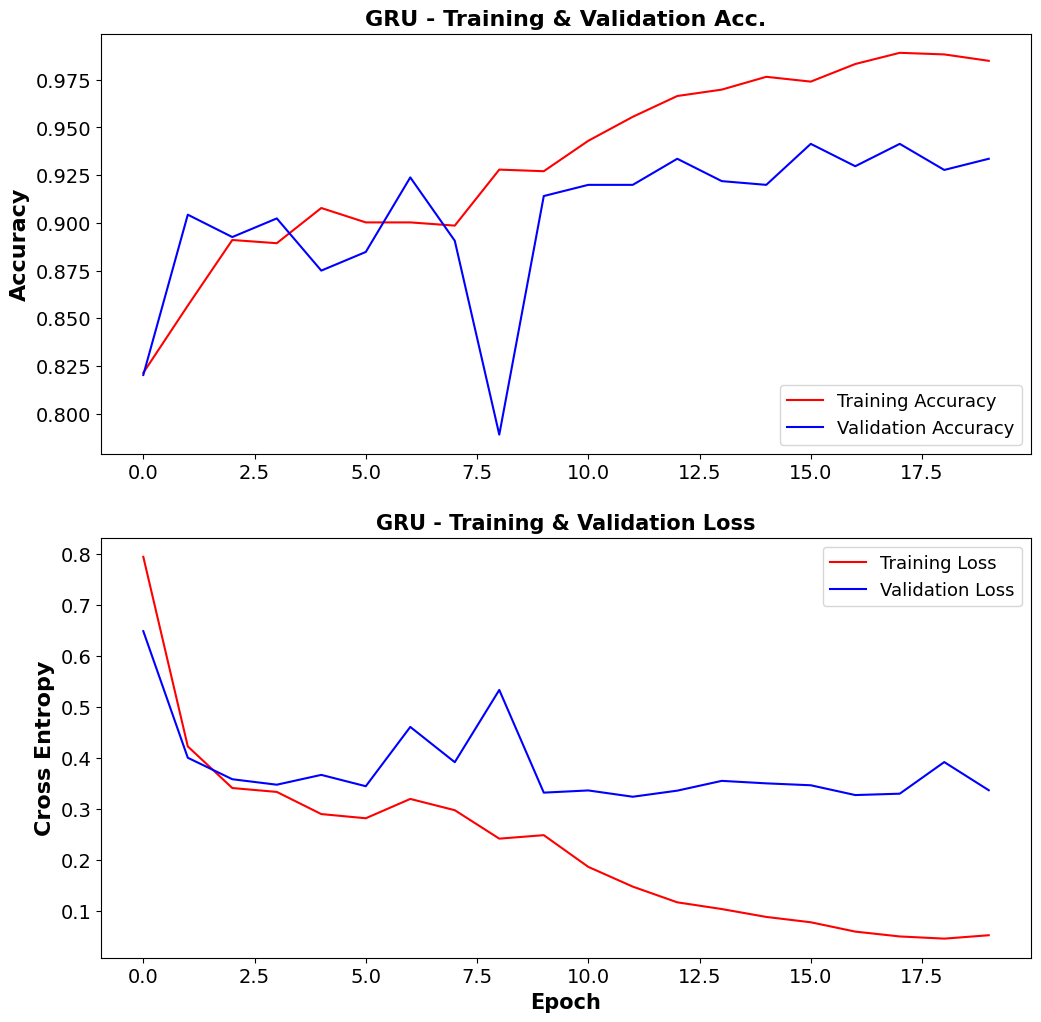

In [ ]:
# Show History
acc = gru_h.history['accuracy']
val_acc = gru_h.history['val_accuracy']

loss = gru_h.history['loss']
val_loss = gru_h.history['val_loss']


plt.figure(figsize=(12, 12))

plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy', color='r')
plt.plot(val_acc, label='Validation Accuracy', color='b')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='lower right', fontsize=13)
plt.ylabel('Accuracy', fontsize=16, weight='bold')
plt.title('GRU - Training & Validation Acc.', fontsize=16, weight='bold')


plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss', color='r')
plt.plot(val_loss, label='Validation Loss', color='b')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='upper right', fontsize=13)
plt.ylabel('Cross Entropy', fontsize=16, weight='bold')
plt.title('GRU - Training & Validation Loss', fontsize=15, weight='bold')
plt.xlabel('Epoch', fontsize=15, weight='bold')

plt.show()

# Testing Model

In [ ]:
gru_model = load_model('./best_gru_model.h5')
gru_acc = gru_model.evaluate(X_test, y_test, verbose=1)[1]
print("Test Acc. GRU: {:.3f}%".format(gru_acc * 100))

14/14 [==============================] - 13s 851ms/step - loss: 0.2378 - accuracy: 0.9391
Test Acc. GRU: 93.911%


In [ ]:
predicted_probabilities = gru_model.predict(X_test)
predicted_labels = np.argmax(predicted_probabilities, axis=1)
true_labels = np.argmax(y_test, axis=1)

14/14 [==============================] - 13s 910ms/step


In [ ]:
# Get predictions from the GRU model
y_pred_proba_gru = gru_model.predict(X_test)
y_pred_gru = np.argmax(y_pred_proba_gru, axis=1)  # Convert probabilities to class labels

# Calculate accuracy
gru_acc = accuracy_score(y_test, y_pred_gru)

# Calculate precision
gru_precision = precision_score(y_test, y_pred_gru, average='macro')

# Calculate recall
gru_recall = recall_score(y_test, y_pred_gru, average='macro')

# Calculate F1-score
gru_f1 = f1_score(y_test, y_pred_gru, average='macro')

print("Test Accuracy (GRU): {:.3f}%".format(gru_acc * 100))
print("Precision (GRU): {:.3f}".format(gru_precision))
print("Recall (GRU): {:.3f}".format(gru_recall))
print("F1-score (GRU): {:.3f}".format(gru_f1))


14/14 [==============================] - 12s 842ms/step


ValueError: Classification metrics can't handle a mix of multilabel-indicator and multiclass targets

# Evaluating Model

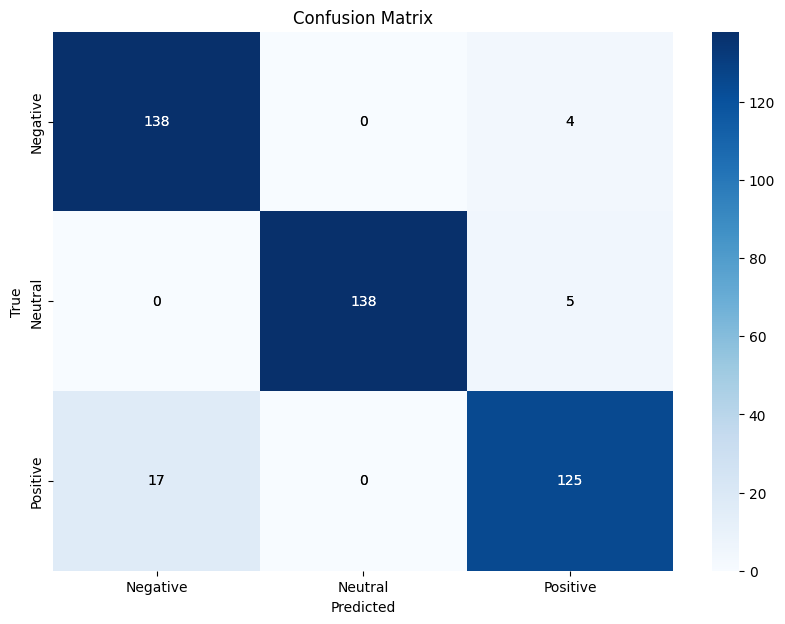

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(true_labels, predicted_labels)

# Define the labels for your confusion matrix
labels = ['Negative', 'Neutral', 'Positive']

# Function to apply color to annotation based on value
def get_annotation_color(value):
    if value > np.max(cm) / 2:
        return "white"  # White text for dark cells
    else:
        return "black"  # Black text for light cells

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels,
                 vmin=0)  # Ensure the color scale starts at zero

# Loop over data dimensions and create text annotations with the correct color.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j+0.5, i+0.5, cm[i, j],
                ha="center", va="center",
                color=get_annotation_color(cm[i, j]))

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()